# Manage Papers

This notebook selects papers to read from whom and parses references.
It also filters the indices of passed papers from the search results and creates the table `papers_passed` that is annotated as `papers_annotated` in the google spreadsheet.

In [1]:
# %pip install -r requirements.txt

In [2]:
import os
import sys
import time
from datetime import datetime
from unidecode import unidecode

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import seaborn as sns

## Load Search Results

In [3]:
df = pd.read_csv("Search/all_searchresults.csv")
df.index += 1  # increment index such that it fits with the used indices
df.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI
1,35443219,Naturalistic viewing conditions can increase t...,"Welke D, Vessel EA.",Neuroimage. 2022 Aug 1;256:119218. doi: 10.101...,Welke D,Neuroimage,2022,2022/04/20,NaN,NaN,10.1016/j.neuroimage.2022.119218
2,35278015,Zapline-plus: A Zapline extension for automati...,"Klug M, Kloosterman NA.",Hum Brain Mapp. 2022 Jun 15;43(9):2743-2758. d...,Klug M,Hum Brain Mapp,2022,2022/03/12,PMC9120550,NaN,10.1002/hbm.25832


In [4]:
passed = !ls Results/PASS
passed_idxs = sorted([int(paper.split("]_")[0].split("[")[-1]) for paper in passed])
df = df.loc[passed_idxs]
print(df.shape)

(90, 11)


## Create unique IDs for the References in the style of 'Jung01b'

In [5]:
# create unique IDs
def create_ref_id(row):
    # print(row)
    author = unidecode(row["First Author"].split(" ")[0])
    if author in ["van", "von", "de"]:
        author = unidecode(row["First Author"].split(" ")[1])
    year = str(row["Publication Year"])[2:]
    return author + year

df["Ref"] = df.apply(create_ref_id, axis=1)
dupl = pd.value_counts(df["Ref"])
duplicates = dict({a: 0 for a in dupl[dupl>1].index})
for idx, ref in df["Ref"].iteritems():
    if ref in duplicates.keys():
        df.loc[idx, "Ref"] = ref + "abcde"[duplicates[ref]]
        duplicates[ref] = duplicates[ref] + 1

In [6]:
# the refs must be unique
df[df["First Author"].str.contains("Jung")]

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Ref
724,11559961,Analysis and visualization of single-trial eve...,"Jung TP, Makeig S, Westerfield M, Townsend J, ...",Hum Brain Mapp. 2001 Nov;14(3):166-85. doi: 10...,Jung TP,Hum Brain Mapp,2001,2001/09/18,PMC6871967,NaN,10.1002/hbm.1050,Jung01a
725,20824156,Imaging Brain Dynamics Using Independent Compo...,"Jung TP, Makeig S, McKeown MJ, Bell AJ, Lee TW...",Proc IEEE Inst Electr Electron Eng. 2001 Jul 1...,Jung TP,Proc IEEE Inst Electr Electron Eng,2001,2010/09/09,PMC2932458,HHMIMS197143,10.1109/5.939827,Jung01b


In [7]:
assert len(df["Ref"].unique()) == df.shape[0]

In [8]:
df.head()

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Ref
8,35590859,Motion Artifacts Correction from Single-Channe...,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, ...",Sensors (Basel). 2022 Apr 21;22(9):3169. doi: ...,Hossain MS,Sensors (Basel),2022,2022/05/20,PMC9102309,NaN,10.3390/s22093169,Hossain22
10,35459033,Improved Cognitive Vigilance Assessment after ...,"Abu Farha N, Al-Shargie F, Tariq U, Al-Nashash H.",Sensors (Basel). 2022 Apr 15;22(8):3051. doi: ...,Abu Farha N,Sensors (Basel),2022,2022/04/23,PMC9033092,NaN,10.3390/s22083051,Abu22
16,35093730,Automated Pipeline for Infants Continuous EEG ...,"Fló A, Gennari G, Benjamin L, Dehaene-Lambertz G.",Dev Cogn Neurosci. 2022 Apr;54:101077. doi: 10...,Fló A,Dev Cogn Neurosci,2022,2022/01/30,PMC8804179,NaN,10.1016/j.dcn.2022.101077,Flo22
17,35085870,NEAR: An artifact removal pipeline for human n...,"Kumaravel VP, Farella E, Parise E, Buiatti M.",Dev Cogn Neurosci. 2022 Apr;54:101068. doi: 10...,Kumaravel VP,Dev Cogn Neurosci,2022,2022/01/27,PMC8800139,NaN,10.1016/j.dcn.2022.101068,Kumaravel22
35,34924988,A Toolbox and Crowdsourcing Platform for Autom...,"Soghoyan G, Ledovsky A, Nekrashevich M, Martyn...",Front Neuroinform. 2021 Dec 2;15:720229. doi: ...,Soghoyan G,Front Neuroinform,2021,2021/12/20,PMC8675888,NaN,10.3389/fninf.2021.720229,Soghoyan21


In [9]:
# save the table of passed papers into a file
df.to_csv("output/papers_passed.csv", index=False)

## Basic explorative analysis

In [10]:
df["Publication Year"].describe()

count      90.000000
mean     2015.877778
std         4.930592
min      2001.000000
25%      2014.000000
50%      2017.000000
75%      2019.000000
max      2022.000000
Name: Publication Year, dtype: float64

In [11]:
# only four journals are relevant
df["Journal/Book"].value_counts()[:10]

Front Neurosci                         11
J Neurosci Methods                      9
Sensors (Basel)                         8
Front Hum Neurosci                      7
Neuroimage                              3
PLoS One                                3
Psychophysiology                        3
J Healthc Eng                           3
Entropy (Basel)                         2
Annu Int Conf IEEE Eng Med Biol Soc     2
Name: Journal/Book, dtype: int64

In [12]:
# only 2 authors have more than 4 publications, only 11 three or more.
authors = df["Authors"].str.split(",")
authors = [unidecode(a.strip().replace(".", "")) for p in authors for a in p]
counts = pd.DataFrame(authors).value_counts()
print(f"Number of unique authors: {len(counts)}, number of total authors: {len(authors)}")
counts[:20]

Number of unique authors: 388, number of total authors: 451


Ferris DP             9
Hairston WD           7
Makeig S              4
Maxwell JS            3
Lawhern V             3
Chen X                3
Greischar LL          3
Davidson RJ           3
Shackman AJ           3
Nordin AD             3
McMenamin BW          3
Jung TP               2
Huang HJ              2
Vaidya MP             2
Tamburro G            2
Kline JE              2
Comani S              2
Contreras-Vidal JL    2
Fiedler P             2
Snyder KL             2
dtype: int64

### Plot the Journal counts over time

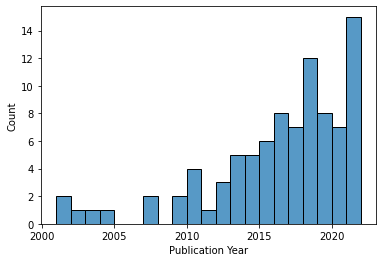

In [13]:
sns.histplot(data=df, x="Publication Year", binwidth=1)
plt.show()

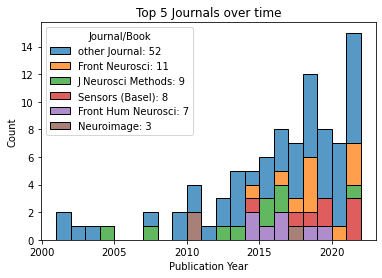

In [14]:
# Get the journals in order by ascending counts, also in the dataframe
top_n = 5
joi = df["Journal/Book"].value_counts()[:top_n]
other_j = "other Journal"
df_ = df.copy()
df_["Journal/Book"] = df_["Journal/Book"].apply(lambda j: j if j in joi else other_j)
journals = list(df_["Journal/Book"].value_counts().index)
j_counts = list(df_["Journal/Book"].value_counts())
journals.remove(other_j)
journals = [other_j] + journals
df_["Journal/Book"] = pd.Categorical(df_["Journal/Book"], journals)

# Append the journal counts to their names in the dataframe
label_dict = {j: f"{j}: {j_counts[i]}" for i, j in enumerate(journals)}
df_["Journal/Book"] = df_["Journal/Book"].map(label_dict)

# Plot the histogram
sns.histplot(data=df_, x="Publication Year", hue="Journal/Book", multiple="stack", binwidth=1
            ).set(title=f"Top {top_n} Journals over time")
plt.show()

## Partitionate the Papers for reading

In [15]:
np.random.seed(0)
rand_vec = np.random.permutation(df.shape[0])
rand_vec

array([ 2, 13, 53, 41, 66, 30, 45, 43, 78, 89,  7, 26, 33, 63,  8, 16, 24,
       56, 77, 42, 22,  6, 61, 48, 80, 54, 73, 79, 82,  3, 62, 75, 27, 18,
       50, 51, 74, 59, 55,  4, 15, 17, 40, 38,  5, 81, 68,  0, 34, 28, 11,
       35, 23, 52, 10, 31, 60, 57, 71,  1, 32, 76, 14, 85, 19, 29, 49, 87,
       88, 69, 20, 84, 72, 25, 37, 46, 39, 65, 58, 12, 70, 36, 21, 83,  9,
       86, 67, 64, 47, 44])

## Papers for MST and for CS

In [16]:
# Papers for Chris
df.iloc[rand_vec[:40]].index

Int64Index([16, 86, 389, 281, 482, 228, 328, 300, 615, 725, 52, 194, 241, 451, 54, 106, 163, 405, 609, 293, 156, 47, 444, 347, 628, 392, 549, 624, 648, 17, 447, 551, 196, 126, 370, 377, 550, 420, 400, 35], dtype='int64')

In [17]:
# Papers for both of us
df.iloc[rand_vec[40:45]]

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Ref
104,33328870,Refinement of High-Gamma EEG Features From TBI...,"Li Y, Wang PT, Vaidya MP, Flint RD, Liu CY, Sl...",Front Neurosci. 2020 Nov 24;14:599010. doi: 10...,Li Y,Front Neurosci,2020,2020/12/17,PMC7732541,NaN,10.3389/fnins.2020.599010,Li20
117,32943621,Fully organic compliant dry electrodes self-ad...,"Zhang L, Kumar KS, He H, Cai CJ, He X, Gao H, ...",Nat Commun. 2020 Sep 17;11(1):4683. doi: 10.10...,Zhang L,Nat Commun,2020,2020/09/18,PMC7499260,NaN,10.1038/s41467-020-18503-8,Zhang20
275,29492336,A new ICA-based fingerprint method for the aut...,"Tamburro G, Fiedler P, Stone D, Haueisen J, Co...",PeerJ. 2018 Feb 23;6:e4380. doi: 10.7717/peerj...,Tamburro G,PeerJ,2018,2018/03/02,PMC5826009,NaN,10.7717/peerj.4380,Tamburro18
272,29322469,Removal of muscular artifacts in EEG signals: ...,"Frølich L, Dowding I.",Brain Inform. 2018 Mar;5(1):13-22. doi: 10.100...,Frølich L,Brain Inform,2018,2018/01/12,PMC5893498,NaN,10.1007/s40708-017-0074-6,Frolich18
40,34833790,The Influence of Filters on EEG-ERP Testing: A...,"Karpiel I, Kurasz Z, Kurasz R, Duch K.",Sensors (Basel). 2021 Nov 19;21(22):7711. doi:...,Karpiel I,Sensors (Basel),2021,2021/11/27,PMC8619013,NaN,10.3390/s21227711,Karpiel21


In [18]:
# Papers for Mat
df.iloc[rand_vec[45:]].index

Int64Index([640, 506, 8, 248, 207, 77, 259, 162, 384, 73, 235, 431, 406, 524, 10, 240, 583, 89, 707, 139, 216, 356, 723, 724, 509, 144, 684, 538, 171, 268, 333, 273, 465, 408, 82, 513, 265, 145, 672, 56, 713, 490, 455, 345, 301], dtype='int64')

## Create the bibtex-file

Using a [webservice](https://scipython.com/blog/doi-to-bibtex/#comments) for the parsing.

@Article{article,  
	author = "Author1 LastName1 and Author2 LastName2 and Author3 LastName3",  
	title = "Article Title",  
	volume = "30",  
	number = "30",  
	pages = "10127-10134",  
	year = "2013",  
	doi = "10.3389/fnins.2013.12345",  
	URL = "http://www.frontiersin.org/Journal/10.3389/fnins.2013.12345/abstract",  
	journal = "Frontiers in Neuroscience"  
}

In [19]:
import sys
import urllib.request
from urllib.error import HTTPError

BASE_URL = 'http://dx.doi.org/'

In [20]:
df[["Ref", "DOI"]].head(2)

,Ref,DOI
8,Hossain22,10.3390/s22093169
10,Abu22,10.3390/s22083051


In [21]:
reviewed_bibtex = str()

for idx, row in df.iterrows():
    print(f"parsing {row['Ref']}")
    ref = row["Ref"]
    doi = row["DOI"]
    
    # create specific doi-url
    url = BASE_URL + doi
    req = urllib.request.Request(url)
    req.add_header('Accept', 'application/x-bibtex')
    
    # parse content
    try:
        with urllib.request.urlopen(req) as f:
            bibtex = f.read().decode()
    except HTTPError as e:
        if e.code == 404:
            print('DOI not found.')
        else:
            print('Service unavailable.')
        print(row)

    # replace the article id
    original_id = bibtex.split("\n")[0].split("{")[1]
    bibtex = bibtex.split("{")[0] + "{" + row["Ref"] + ",\n" + "\n".join(bibtex.split("\n")[1:])
    
    # append to bibtex file
    reviewed_bibtex += bibtex
    reviewed_bibtex += "\n"
    
    break  # TODO remove break to parse all files

parsing Hossain22


In [22]:
# write to file if all papers have been parsed
if reviewed_bibtex.count("@") == df.shape[0]:
    with open("output/reviewed_papers.bib", "w") as f:
        f.write(reviewed_bibtex)

print(reviewed_bibtex[:500])

@article{Hossain22,
	doi = {10.3390/s22093169},
	url = {https://doi.org/10.3390%2Fs22093169},
	year = 2022,
	month = {apr},
	publisher = {{MDPI} {AG}},
	volume = {22},
	number = {9},
	pages = {3169},
	author = {Md Shafayet Hossain and Muhammad E. H. Chowdhury and Mamun Bin Ibne Reaz and Sawal Hamid Md Ali and Ahmad Ashrif A. Bakar and Serkan Kiranyaz and Amith Khandakar and Mohammed Alhatou and Rumana Habib and Muhammad Maqsud Hossain},
	title = {Motion Artifacts Correction from Single-Channel {
